In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Sequence, Tuple
import pandas as pd
from collections import OrderedDict, defaultdict
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation for the image dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training and testing sets
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Define a simple CNN model for image classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model on each client's data and save the weights
client_models = []
epochs = 20
criterion = nn.CrossEntropyLoss()

def train_model(model, trainloader, epochs, criterion):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return model

# Train the model
model = SimpleCNN()
trained_model = train_model(model, trainloader, epochs, criterion)

# Function to get the top 30% contributing pixels
def get_top_contributing_pixels(model, data, percentage=0.3):
    model.eval()
    with torch.no_grad():
        data = data.unsqueeze(0)  # Add batch dimension
        output = model(data)
        output = torch.softmax(output, dim=1)
        top_pixels = output.topk(int(data.numel() * percentage), dim=1, largest=True, sorted=True)
        return top_pixels.indices

# Get a test image
test_images, _ = next(iter(testloader))
test_image = test_images[0]

# Get the top 30% contributing pixels
top_pixels = get_top_contributing_pixels(trained_model, test_image)

# Highlight the top 30% pixels in the image
highlighted_image = test_image.clone()
highlighted_image = highlighted_image.numpy().transpose(1, 2, 0)

# Convert top_pixels to coordinates
top_pixels = top_pixels.squeeze().cpu().numpy()
highlighted_coords = np.unravel_index(top_pixels, test_image.shape[1:])

# Create a mask to highlight the top contributing pixels
mask = np.zeros_like(test_image.numpy().transpose(1, 2, 0))
mask[highlighted_coords[1], highlighted_coords[2], :] = 1

# Highlight the pixels by adding a red color
highlighted_image[mask == 1] = [1, 0, 0]

# Plot the original and highlighted image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image.numpy().transpose(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Highlighted Image")
plt.imshow(highlighted_image)
plt.axis('off')
plt.show()


100%|██████████| 170498071/170498071 [00:02<00:00, 74119079.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


RuntimeError: selected index k out of range

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict, defaultdict
import torch.nn.functional as F
model_equations = []
from typing import Sequence, Tuple

def fed_model(testimages):
    # Load the heart disease dataset
    data = pd.read_csv('/content/heart_disease_uci.csv')  # Update this to the actual path of your heart dataset CSV file
    X = data.drop(columns=['num'])
    y = data['num']

    # Convert categorical variables to numerical
    X = pd.get_dummies(X, columns=['sex', 'cp', 'restecg', 'exang', 'slope', 'thal'])

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Number of clients
    n_clients = 3

    # Split the training data into n_clients parts
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, n_clients)

    # Create data loaders for each client
    client_loaders = []
    batch_size = 16
    for client_indices in split_indices:
        client_subset = Subset(train_dataset, client_indices)
        client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(client_loader)

    # Define a simple feedforward neural network model
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(X.shape[1], 50)  # Adjust input size to match the number of features
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, len(y.unique()))  # Adjust output size to match the number of classes
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Train the model on each client's data and save the weights
    client_models = []
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    for i, loader in enumerate(client_loaders):
        model = SimpleNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Training loop
        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            # print(f'Client {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(loader)}')

        # Save the model weights
        torch.save(model.state_dict(), f'client_{i+1}_model.pth')
        client_models.append(model.state_dict())
        sums = defaultdict(int)
        count = len(client_models)
        for od in client_models:
            for key, value in od.items():
                sums[key] += value

        # Calculate the average for each key
        averages = {key: value / count for key, value in sums.items()}

        # Convert the averages to an OrderedDict (optional)
        average_ordereddict = OrderedDict(averages)

        model.load_state_dict(average_ordereddict)
        testimages = torch.tensor(testimages, dtype=torch.float32)
        y_test = model(testimages)
        return y_test

    # print("Training complete and weights saved for each client model.")

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

# Base Model class (assuming you have this implemented)
class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name

# FeatureNN class (assuming you have this implemented)
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

# NAM model definition
class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), len(y.unique()))  # Adjust output size
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        print("feature_names")
        print(feature_names)
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)

        # Determine feature interpretability based on coefficients
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0]  # Return the feature with the highest contribution

n_clients = 3
# Load the heart disease dataset
data = pd.read_csv('/content/heart_disease_uci.csv')  # Update this to the actual path of your heart dataset CSV file
df = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the DataFrame

# Split the data into n_clients
client_data = [df.iloc[i * len(df) // n_clients: (i + 1) * len(df) // n_clients] for i in range(n_clients)]

# Separate features and target for each client
clients_features = [client.drop(columns=['num']) for client in client_data]
clients_targets = [client['num'] for client in client_data]

for i in range(n_clients):
    feature_columns = clients_features[i].columns.tolist()
    df = clients_features[i].head()

    target = clients_targets[i].head()
    X = df.values
    y = target.values

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Define the config
    config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)

    # Instantiate the NAM model
    num_inputs = len(feature_columns)  # Number of features
    num_units = 10  # Number of units in the hidden layer
    nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)

    # Training function
    def train(model, X_train, y_train, config):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        model.train()
        for epoch in range(config.num_epochs):
            outputs = fed_model(X_test_tensor)
            optimizer.zero_grad()
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
        return model

    # Evaluation function
    def evaluate(model, X_test, y_test):
        model.eval()
        with torch.no_grad():
            outputs, _ = model(X_test)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            print(f'Accuracy: {accuracy * 100:.2f}%')

    # Train the model
    trained_model = train(nam_model, X_train_tensor, y_train_tensor, config)

    # Evaluate the model
    evaluate(trained_model, X_test_tensor, y_test_tensor)

    # Print the model equation and get the most contributing feature
    most_contributing_feature = trained_model.print_model_equation(feature_columns)
    print(f"\nMost contributing feature for client's output {i}: {most_contributing_feature}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/heart_disease_uci.csv'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Sequence, Tuple
import pandas as pd
from sklearn.datasets import fetch_openml
from collections import OrderedDict, defaultdict
import torch.nn.functional as F
model_equations = []

def fed_model(testimages):
    # Load the Wine Quality dataset
    wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
    X = wine.data
    y = wine.target
    y = wine.target.astype(int)  # Ensure the target values are integers

    # Adjust target values: map 3 to 0, 9 to 6, and shift other values accordingly
    def adjust_target(value):
        if value == 3:
            return 0
        elif value == 9:
            return 6
        else:
            return value - 3

    y = y.apply(adjust_target)
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train = y_train.astype(int)
    y_train_np = y_train.to_numpy().astype(int)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = y_test.astype(int)
    y_test_np = y_test.to_numpy()
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Number of clients
    n_clients = 3

    # Split the training data into n_clients parts
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, n_clients)

    # Create data loaders for each client
    client_loaders = []
    batch_size = 16
    for client_indices in split_indices:
        client_subset = Subset(train_dataset, client_indices)
        client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(client_loader)

    # Define a simple feedforward neural network model
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(11, 50)  # Adjust input size to match the number of features (11)
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, 6)  # Adjust output size to match the number of classes (6)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Train the model on each client's data and save the weights
    client_models = []
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    for i, loader in enumerate(client_loaders):
        model = SimpleNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Training loop
        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            # print(f'Client {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(loader)}')

        # Save the model weights
        torch.save(model.state_dict(), f'client_{i+1}_model.pth')
        client_models.append(model.state_dict())
        sums = defaultdict(int)
        count = len(client_models)
        for od in client_models:
            for key, value in od.items():
                sums[key] += value

        # Calculate the average for each key
        averages = {key: value / count for key, value in sums.items()}

        # Convert the averages to an OrderedDict (optional)
        average_ordereddict = OrderedDict(averages)

        model.load_state_dict(average_ordereddict)
        testimages = torch.tensor(testimages, dtype=torch.float32)
        y_test = model(testimages)
        return y_test

    # print("Training complete and weights saved for each client model.")

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

# Base Model class (assuming you have this implemented)
class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name

# FeatureNN class (assuming you have this implemented)
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

# NAM model definition
class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), 3)  # 3 classes for Iris dataset
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        print("feature_names")
        print(feature_names)
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)

        # Determine feature interpretability based on coefficients
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0]  # Return the feature with the highest contribution

n_clients = 3
# Load sample dataset
data = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # Ensure the target column is added to the DataFrame

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into n_clients
client_data = [df.iloc[i * len(df) // n_clients: (i + 1) * len(df) // n_clients] for i in range(n_clients)]

# Separate features and target for each client
clients_features = [client.drop(columns=['target']) for client in client_data]
clients_targets = [client['target'] for client in client_data]
clients_targets = [target.astype(int) for target in clients_targets]

# Separate features and target for each client
clients_features = [client.drop(columns=['target']) for client in client_data]

for i in range(n_clients):
    feature_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

    df = clients_features[i].head()

    def adjust_target(value):
        return value - 3

    target = clients_targets[i].head()
    X = df[feature_columns].values
    y = target
    y = target.apply(adjust_target)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train = y_train.astype(int)
    y_train_np = y_train.to_numpy().astype(int)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = y_test.astype(int)
    y_test_np = y_test.to_numpy()
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

    # Define the config
    config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)

    # Instantiate the NAM model
    num_inputs = len(feature_columns)  # Number of features
    num_units = 10  # Number of units in the hidden layer
    nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)

    # Training function
    def train(model, X_train, y_train, config):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        model.train()
        for epoch in range(config.num_epochs):
            outputs = fed_model(X_test_tensor)
            optimizer.zero_grad()
            y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
            loss = criterion(outputs, y_test_tensor)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
        return model

    # Evaluation function
    def evaluate(model, X_test, y_test):
        model.eval()
        with torch.no_grad():
            outputs, _ = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            print(f'Accuracy: {accuracy * 100:.2f}%')

    # Train the model
    trained_model = train(nam_model, X_train_tensor, y_train_tensor, config)

    # Evaluate the model
    evaluate(trained_model, X_test_tensor, y_test_tensor)

    # Print the model equation and get the most contributing feature
    most_contributing_feature = trained_model.print_model_equation(feature_columns)
    print(f"\nMost contributing feature for client's output {i}: {most_contributing_feature}")

<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [10/50], Loss: 6.7640


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [20/50], Loss: 9.3057


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [30/50], Loss: 19.7133


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [40/50], Loss: 14.9803


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [50/50], Loss: 9.2738
Accuracy: 0.00%
feature_names
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Model Equation: y = (0.973 * x_fixed_acidity + -0.054) + (-0.791 * x_fixed_acidity + -0.868) + (-0.251 * x_fixed_acidity + -0.176) + (-0.626 * x_fixed_acidity + -0.278) + (0.846 * x_fixed_acidity + 0.177) + (-0.436 * x_fixed_acidity + 0.303) + (-0.983 * x_fixed_acidity + 0.692) + (0.213 * x_fixed_acidity + -0.997) + (-0.731 * x_fixed_acidity + -0.275) + (0.449 * x_fixed_acidity + -0.872) + (0.415 * x_volatile_acidity + 0.958) + (-0.956 * x_volatile_acidity + 0.364) + (-0.339 * x_volatile_acidity + -0.893) + (-0.639 * x_volatile_acidity + 0.866) + (-0.806 * x_volatile_acidity + 0.742) + (-0.272 * x_volatile_acidity + 0.980) + (-0.023 * x_volatile_acidity + 0.899) + (-0.333 * x_volatile_acidity + -0.278) + (0.892 * x_volatile_acidity + 0.417) + (-0.498 * x_volat

<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [10/50], Loss: 2.7324


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [20/50], Loss: 3.8473


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [30/50], Loss: 2.5374


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [40/50], Loss: 1.7789


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [50/50], Loss: 8.7301
Accuracy: 0.00%
feature_names
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Model Equation: y = (-0.550 * x_fixed_acidity + -0.826) + (-0.976 * x_fixed_acidity + 0.772) + (0.812 * x_fixed_acidity + -0.298) + (-0.028 * x_fixed_acidity + 0.766) + (-0.276 * x_fixed_acidity + 0.196) + (0.886 * x_fixed_acidity + 0.613) + (0.997 * x_fixed_acidity + -0.344) + (-0.945 * x_fixed_acidity + -0.518) + (-0.772 * x_fixed_acidity + 0.263) + (-0.558 * x_fixed_acidity + -0.498) + (-0.549 * x_volatile_acidity + 0.480) + (-0.470 * x_volatile_acidity + -0.478) + (0.471 * x_volatile_acidity + 0.025) + (0.995 * x_volatile_acidity + 0.084) + (0.854 * x_volatile_acidity + -0.677) + (-0.518 * x_volatile_acidity + 0.599) + (-0.865 * x_volatile_acidity + 0.729) + (0.513 * x_volatile_acidity + 0.206) + (0.044 * x_volatile_acidity + -0.148) + (0.156 * x_volatile_

<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [10/50], Loss: 13.1653


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [20/50], Loss: 2.4300


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [30/50], Loss: 4.8614


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [40/50], Loss: 8.7271


<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

Epoch [50/50], Loss: 2.5850
Accuracy: 0.00%
feature_names
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Model Equation: y = (-0.265 * x_fixed_acidity + 0.247) + (0.715 * x_fixed_acidity + -0.237) + (-0.158 * x_fixed_acidity + 0.857) + (0.103 * x_fixed_acidity + -0.835) + (-0.938 * x_fixed_acidity + -0.387) + (-0.411 * x_fixed_acidity + 0.651) + (-0.172 * x_fixed_acidity + -0.650) + (0.911 * x_fixed_acidity + 0.733) + (-0.020 * x_fixed_acidity + -0.046) + (0.621 * x_fixed_acidity + -0.597) + (-1.000 * x_volatile_acidity + -0.307) + (-0.851 * x_volatile_acidity + 0.861) + (0.645 * x_volatile_acidity + -0.510) + (0.722 * x_volatile_acidity + 0.545) + (0.589 * x_volatile_acidity + 0.393) + (0.689 * x_volatile_acidity + 0.841) + (0.630 * x_volatile_acidity + 0.910) + (0.773 * x_volatile_acidity + -0.316) + (-0.985 * x_volatile_acidity + 0.956) + (0.811 * x_volatile_a

<ipython-input-3-99b2e49b861f>:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-3-99b2e49b861f>:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test_tensor, dtype=torch.float32)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import fetch_openml

# Load the Wine Quality dataset
wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
X = wine.data
y = wine.target
y = wine.target.astype(int)  # Ensure the target values are integers

# Adjust target values: map 3 to 0, 9 to 6, and shift other values accordingly
def adjust_target(value):
    if value == 3:
        return 0
    elif value == 9:
        return 6
    else:
        return value - 3

y = y.apply(adjust_target)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train = y_train.astype(int)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.astype(int)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the fully connected neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(11, 50)  # Adjust input size to match the number of features (11)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 6)  # Adjust output size to match the number of classes (6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=20)

# Evaluate the model
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.2f}%')


Epoch 1/20, Loss: 1.3189
Epoch 2/20, Loss: 1.0541
Epoch 3/20, Loss: 0.9972
Epoch 4/20, Loss: 0.9717
Epoch 5/20, Loss: 0.9491
Epoch 6/20, Loss: 0.9502
Epoch 7/20, Loss: 0.9313
Epoch 8/20, Loss: 0.9190
Epoch 9/20, Loss: 0.9095
Epoch 10/20, Loss: 0.9123
Epoch 11/20, Loss: 0.9019
Epoch 12/20, Loss: 0.8956
Epoch 13/20, Loss: 0.8855
Epoch 14/20, Loss: 0.8808
Epoch 15/20, Loss: 0.8702
Epoch 16/20, Loss: 0.8666
Epoch 17/20, Loss: 0.8643
Epoch 18/20, Loss: 0.8582
Epoch 19/20, Loss: 0.8502
Epoch 20/20, Loss: 0.8504
Accuracy: 58.12%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import fetch_openml

# Load the Wine Quality dataset
wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
X = wine.data
y = wine.target
y = wine.target.astype(int)  # Ensure the target values are integers

# Adjust target values: map 3 to 0, 9 to 6, and shift other values accordingly
def adjust_target(value):
    if value == 3:
        return 0
    elif value == 9:
        return 6
    else:
        return value - 3

y = y.apply(adjust_target)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train = y_train.astype(int)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.astype(int)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the fully connected neural network model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import fetch_openml

# Load the Wine Quality dataset
wine = fetch_openml(name='wine-quality-red', version=1, as_frame=True, parser='liac-arff')
X = wine.data
y = wine.target
y = wine.target.astype(int)  # Ensure the target values are integers

# Adjust target values: map 3 to 0, 9 to 6, and shift other values accordingly
def adjust_target(value):
    if value == 3:
        return 0
    elif value == 9:
        return 6
    else:
        return value - 3

y = y.apply(adjust_target)
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train = y_train.astype(int)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.astype(int)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split the training data into 3 clients
n_clients = 3
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)
split_indices = np.array_split(indices, n_clients)

client_loaders = []
batch_size = 16
for client_indices in split_indices:
    client_subset = Subset(train_dataset, client_indices)
    client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(client_loader)

# Define the fully connected neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(11, 50)  # Adjust input size to match the number of features (11)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 6)  # Adjust output size to match the number of classes (6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model on a client's data
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Federated averaging function
def federated_averaging(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(n_clients)], 0).mean(0)
    global_model.load_state_dict(global_dict)

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the global model
global_model = SimpleNN()
criterion = nn.CrossEntropyLoss()

# Federated Learning Process
epochs = 20
for epoch in range(epochs):
    client_models = []
    for i in range(n_clients):
        client_model = SimpleNN()
        optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9)
        train_model(client_model, client_loaders[i], criterion, optimizer, epochs=1)  # Train each client model
        client_models.append(client_model)

    federated_averaging(global_model, client_models)  # Update global model

    # Evaluate the global model
    global_accuracy = evaluate_model(global_model, test_loader)
    print(f'Epoch {epoch+1}/{epochs}, Global Model Accuracy: {global_accuracy:.2f}%')

# Final evaluation of the global model
final_accuracy = evaluate_model(global_model, test_loader)
print(f'Final Global Model Accuracy: {final_accuracy:.2f}%')
# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=20)

# Evaluate the model
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.2f}%')


Epoch 1/1, Loss: 1.7078
Epoch 1/1, Loss: 1.7475
Epoch 1/1, Loss: 1.7330
Epoch 1/20, Global Model Accuracy: 44.38%
Epoch 1/1, Loss: 1.6515
Epoch 1/1, Loss: 1.6630
Epoch 1/1, Loss: 1.7329
Epoch 2/20, Global Model Accuracy: 38.25%
Epoch 1/1, Loss: 1.6920
Epoch 1/1, Loss: 1.7712
Epoch 1/1, Loss: 1.6877
Epoch 3/20, Global Model Accuracy: 44.38%
Epoch 1/1, Loss: 1.6669
Epoch 1/1, Loss: 1.7225
Epoch 1/1, Loss: 1.6607
Epoch 4/20, Global Model Accuracy: 44.62%
Epoch 1/1, Loss: 1.7060
Epoch 1/1, Loss: 1.7670
Epoch 1/1, Loss: 1.7518
Epoch 5/20, Global Model Accuracy: 37.50%
Epoch 1/1, Loss: 1.7540
Epoch 1/1, Loss: 1.7188
Epoch 1/1, Loss: 1.6319
Epoch 6/20, Global Model Accuracy: 37.75%
Epoch 1/1, Loss: 1.6736
Epoch 1/1, Loss: 1.7815
Epoch 1/1, Loss: 1.7340
Epoch 7/20, Global Model Accuracy: 37.75%
Epoch 1/1, Loss: 1.5880
Epoch 1/1, Loss: 1.7401
Epoch 1/1, Loss: 1.7016
Epoch 8/20, Global Model Accuracy: 37.75%
Epoch 1/1, Loss: 1.5980
Epoch 1/1, Loss: 1.6830
Epoch 1/1, Loss: 1.6710
Epoch 9/20, Glob

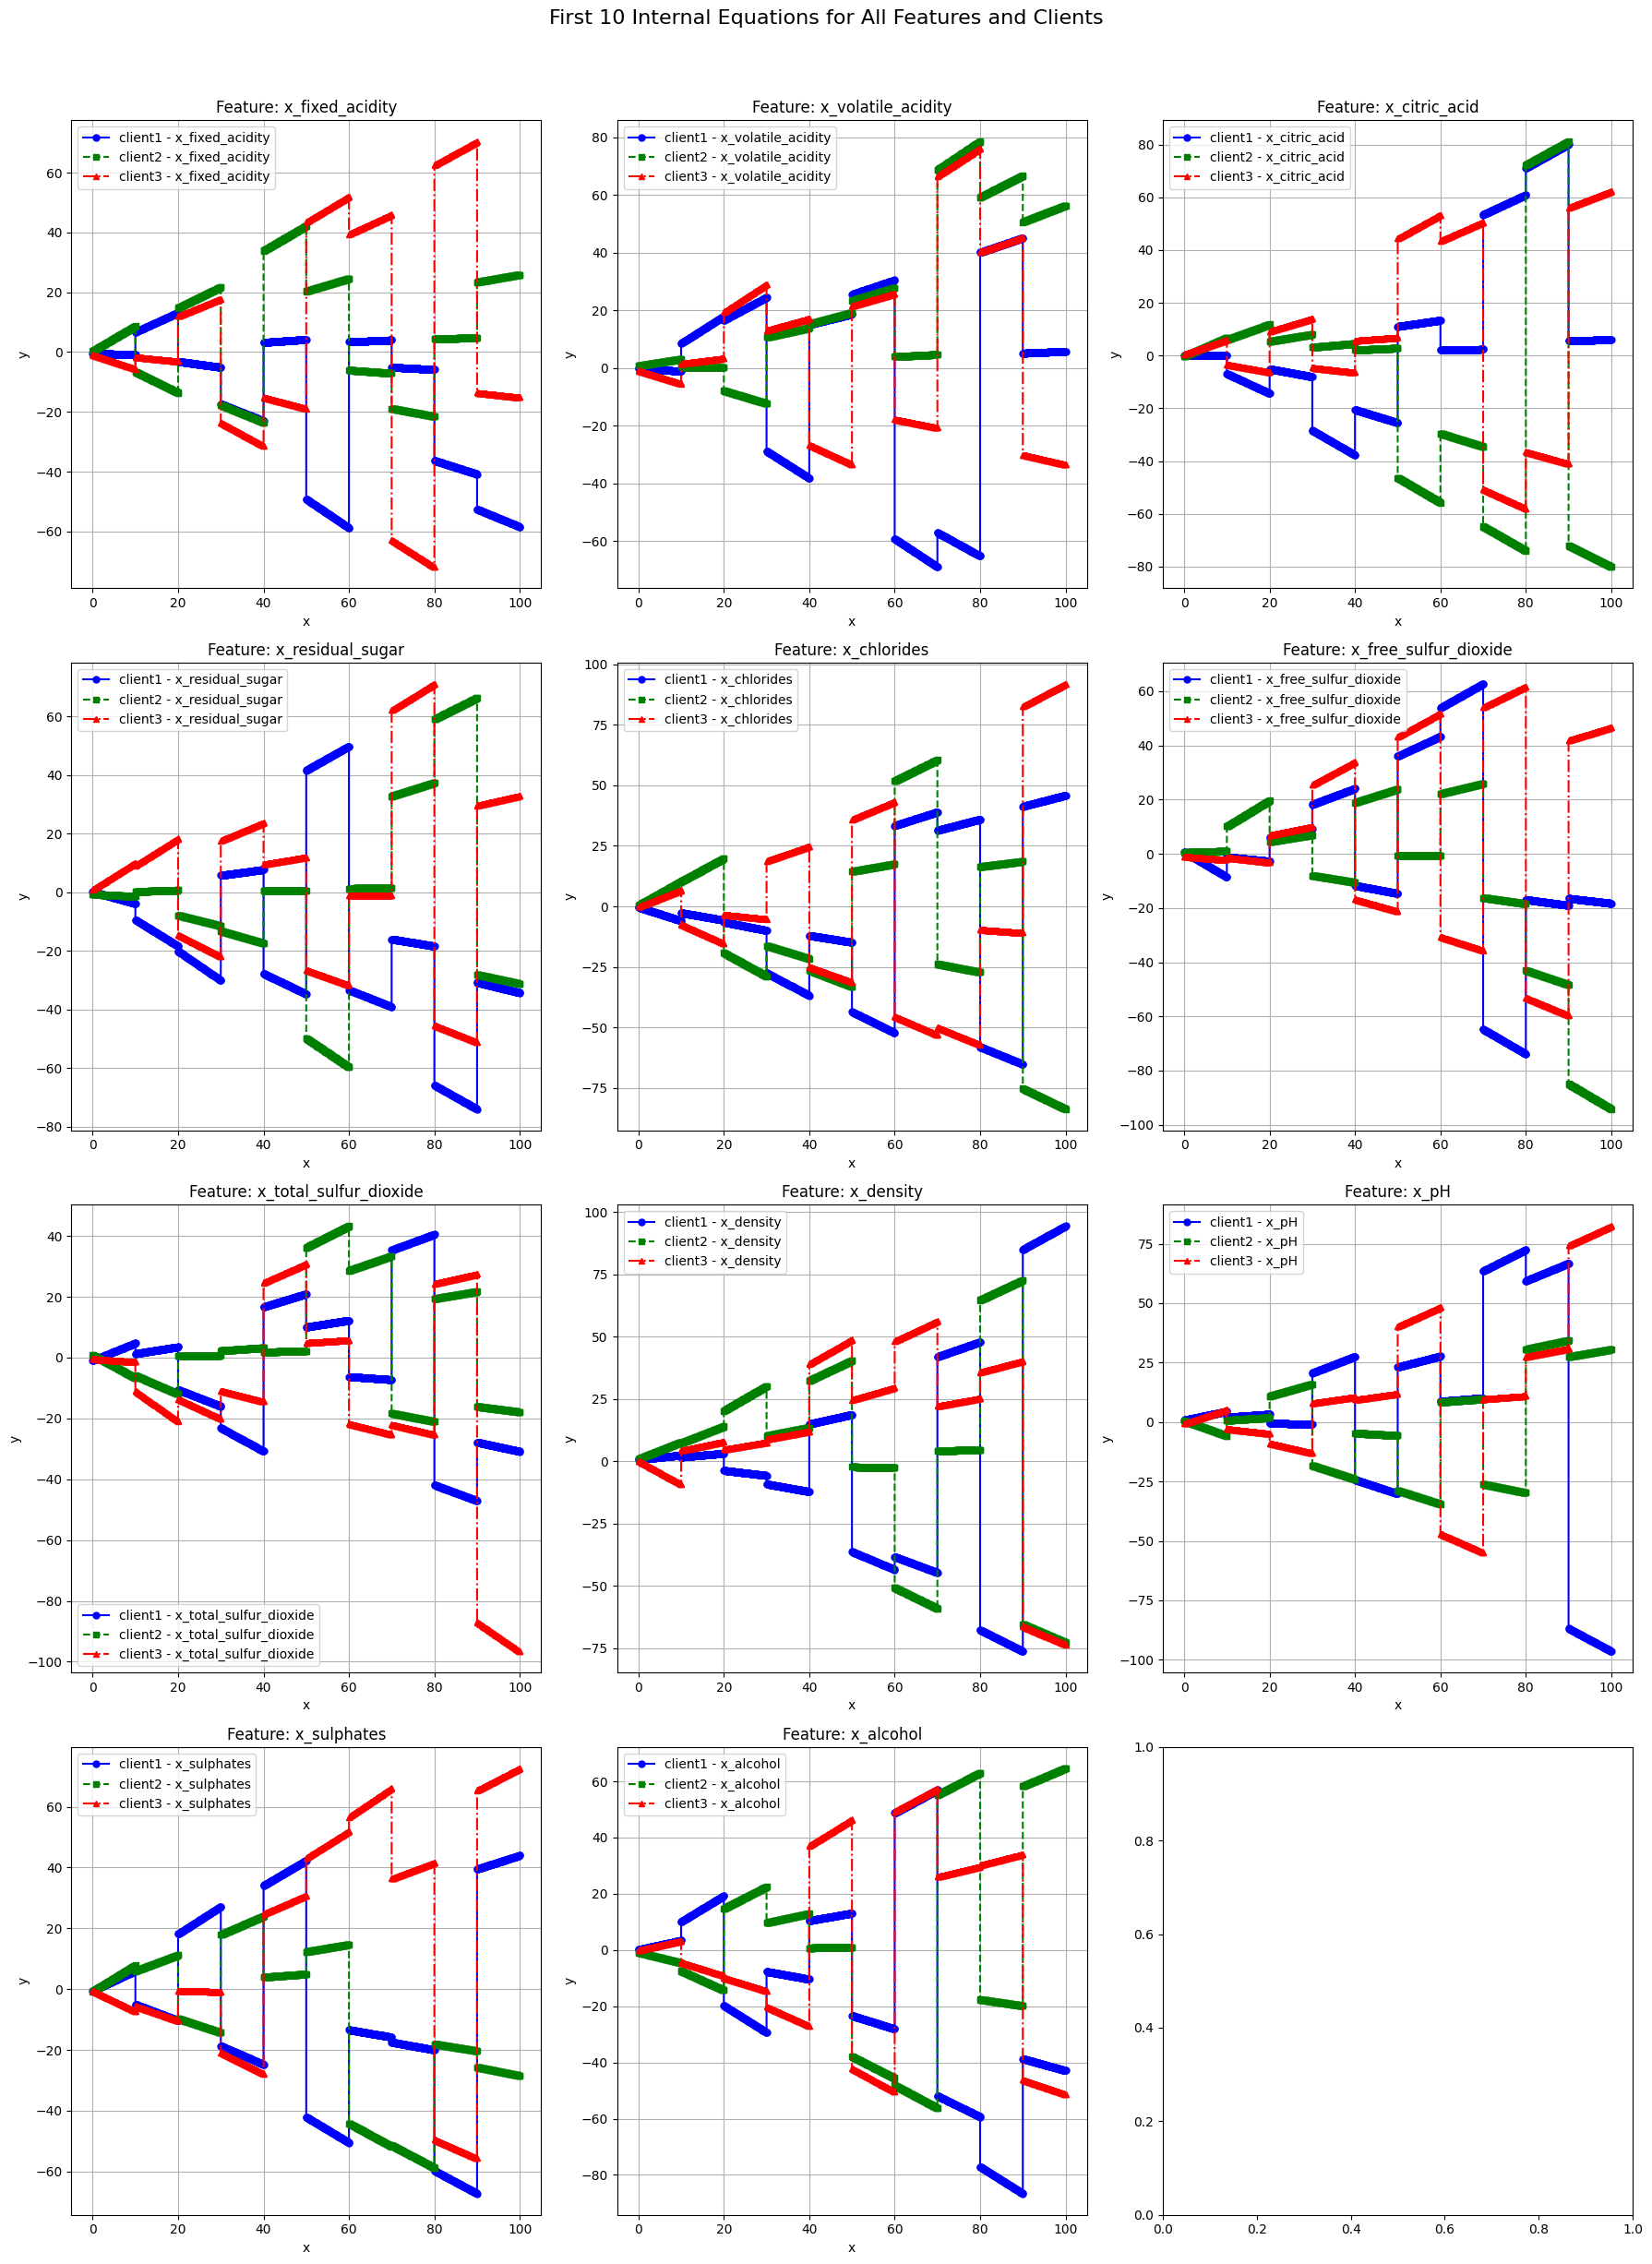

IndexError: list index out of range

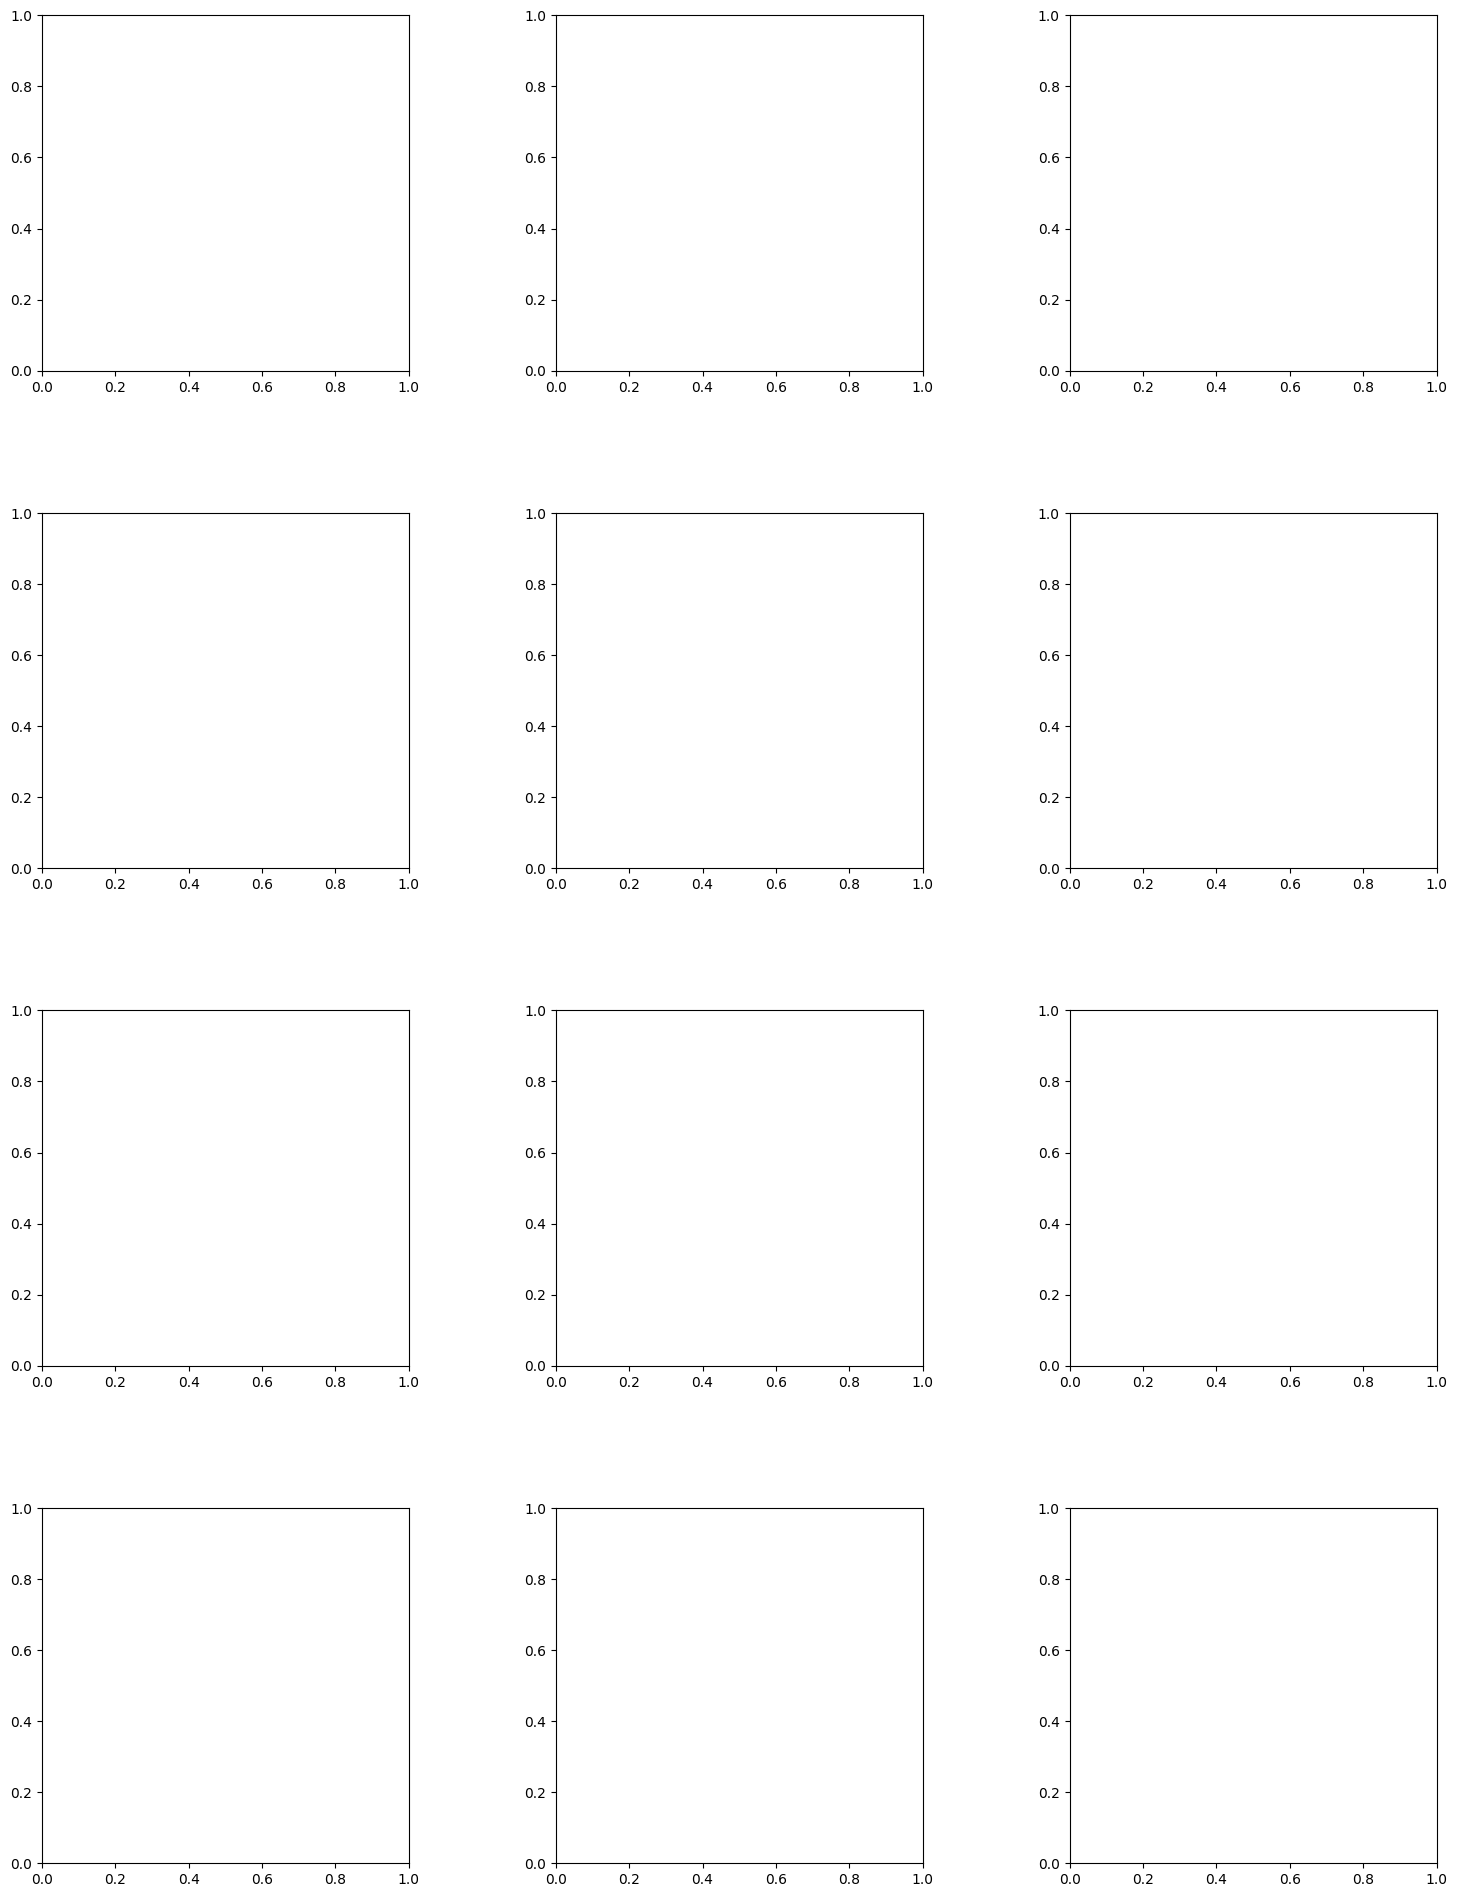

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature and each client
coefficients = {
    "x_fixed_acidity": {
        "client1": [-0.041, 0.651, -0.194, -0.567, 0.100, -0.965, 0.060, -0.074, -0.455, -0.586],
        "client2": [0.836, -0.701, 0.697, -0.585, 0.831, 0.421, -0.103, -0.264, 0.046, 0.250],
        "client3": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155]
    },
    "x_volatile_acidity": {
        "client1": [-0.108, 0.942, 0.795, -0.941, 0.363, 0.496, -0.972, -0.812, 0.504, 0.062],
        "client2": [0.233, -0.013, -0.443, 0.325, 0.394, 0.450, 0.075, 0.989, 0.752, 0.572],
        "client3": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341]
    },
    "x_citric_acid": {
        "client1": [-0.014, -0.745, -0.299, -0.933, -0.494, 0.233, 0.024, 0.751, 0.901, 0.053],
        "client2": [0.710, 0.584, 0.265, 0.138, 0.072, -0.945, -0.497, -0.921, 0.894, -0.810],
        "client3": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618]
    },
    "x_residual_sugar": {
        "client1": [-0.405, -0.898, -0.999, 0.196, -0.699, 0.822, -0.571, -0.235, -0.815, -0.351],
        "client2": [-0.067, 0.049, -0.363, -0.417, 0.019, -0.984, 0.026, 0.458, 0.733, -0.312],
        "client3": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329]
    },
    "x_chlorides": {
        "client1": [-0.559, -0.307, -0.343, -0.927, -0.281, -0.871, 0.565, 0.455, -0.716, 0.457],
        "client2": [0.992, 0.954, -0.970, -0.538, -0.676, 0.307, 0.872, -0.340, 0.217, -0.847],
        "client3": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929]
    },
    "x_free_sulfur_dioxide": {
        "client1": [-0.930, -0.158, 0.334, 0.588, -0.292, 0.729, 0.889, -0.913, -0.213, -0.184],
        "client2": [0.049, 0.956, 0.252, -0.256, 0.497, -0.023, 0.376, -0.226, -0.531, -0.933],
        "client3": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476]
    },
    "x_total_sulfur_dioxide": {
        "client1": [0.567, 0.219, -0.546, -0.764, 0.425, 0.221, -0.099, 0.515, -0.518, -0.299],
        "client2": [-0.761, -0.608, 0.007, 0.097, 0.039, 0.711, 0.484, -0.269, 0.235, -0.179],
        "client3": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964]
    },
    "x_density": {
        "client1": [0.175, 0.149, -0.201, -0.303, 0.380, -0.717, -0.634, 0.594, -0.858, 0.944],
        "client2": [0.678, 0.669, 0.993, 0.334, 0.808, -0.041, -0.836, 0.062, 0.800, -0.732],
        "client3": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726]
    },
    "x_pH": {
        "client1": [0.367, 0.126, -0.067, 0.693, -0.589, 0.459, 0.140, 0.894, 0.740, -0.963],
        "client2": [-0.633, 0.116, 0.510, -0.578, -0.098, -0.570, 0.130, -0.360, 0.373, 0.305],
        "client3": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816]
    },
    "x_sulphates": {
        "client1": [0.657, -0.527, 0.904, -0.611, 0.829, -0.843, -0.238, -0.249, -0.754, 0.448],
        "client2": [0.858, 0.522, -0.461, 0.606, 0.102, 0.232, -0.753, -0.738, -0.229, -0.278],
        "client3": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723]
    },
    "x_alcohol": {
        "client1": [0.330, 0.922, -0.957, -0.273, 0.265, -0.472, 0.820, -0.749, -0.956, -0.420],
        "client2": [-0.372, -0.689, 0.778, 0.324, 0.032, -0.772, -0.816, 0.789, -0.223, 0.642],
        "client3": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
    }
}

intercepts = {
    "x_fixed_acidity": {
        "client1": [-0.436, 0.189, 0.740, -0.334, -0.765, -0.941, -0.162, 0.098, 0.123, 0.150],
        "client2": [0.320, 0.402, 0.824, -0.141, 0.643, -0.676, 0.130, -0.401, 0.694, 0.922],
        "client3": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398]
    },
    "x_volatile_acidity": {
        "client1": [-0.070, -0.899, 0.654, -0.588, 0.530, 0.720, -0.928, -0.236, -0.257, -0.452],
        "client2": [0.743, 0.511, 0.971, 0.881, -0.524, 0.843, -0.586, -0.619, -0.991, -0.862],
        "client3": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637]
    },
    "x_citric_acid": {
        "client1": [0.252, 0.570, 0.928, -0.404, -0.750, -0.602, 0.694, 0.869, -0.964, 0.773],
        "client2": [-0.349, 0.135, 0.084, -0.972, -0.785, 0.931, 0.282, -0.328, 0.686, 0.872],
        "client3": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518]
    },
    "x_residual_sugar": {
        "client1": [0.197, -0.418, -0.108, -0.087, 0.221, 0.545, 0.914, 0.446, -0.662, 0.822],
        "client2": [-0.713, -0.247, -0.572, -0.703, -0.313, -0.653, -0.247, 0.750, 0.412, -0.016],
        "client3": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088]
    },
    "x_chlorides": {
        "client1": [-0.364, 0.408, 0.333, 0.233, -0.804, -0.066, -0.511, -0.401, -0.853, 0.216],
        "client2": [0.336, 0.719, 0.148, -0.100, 0.594, -0.900, -0.513, -0.045, -0.953, 0.854],
        "client3": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869]
    },
    "x_free_sulfur_dioxide": {
        "client1": [0.697, 0.435, -0.723, 0.595, -0.015, -0.397, 0.514, -0.838, 0.152, 0.131],
        "client2": [0.497, 0.533, -0.566, -0.307, -0.966, 0.586, -0.411, -0.361, -0.531, -0.909],
        "client3": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917]
    },
    "x_total_sulfur_dioxide": {
        "client1": [-0.888, -0.861, 0.390, -0.196, -0.292, -0.981, -0.303, -0.653, -0.428, -0.913],
        "client2": [0.908, 0.174, 0.547, -0.644, 0.283, 0.628, -0.426, 0.520, 0.580, 0.035],
        "client3": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179]
    },
    "x_density": {
        "client1": [0.705, 0.198, 0.322, -0.062, -0.244, -0.481, -0.324, 0.403, 0.876, 0.069],
        "client2": [0.896, 0.626, 0.386, 0.195, 0.033, -0.230, -0.635, -0.261, 0.696, 0.422],
        "client3": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934]
    },
    "x_pH": {
        "client1": [0.832, 0.799, 0.950, -0.143, -0.700, 0.174, 0.344, 0.935, 0.165, -0.120],
        "client2": [0.524, -0.444, 0.668, -0.927, -0.780, -0.293, 0.596, -0.946, 0.754, 0.024],
        "client3": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826]
    },
    "x_sulphates": {
        "client1": [-0.546, 0.230, 0.040, -0.345, 0.890, 0.062, 0.874, -0.049, 0.590, -0.812],
        "client2": [-0.781, 0.752, -0.478, -0.267, -0.139, 0.723, 0.975, 0.247, 0.266, -0.679],
        "client3": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369]
    },
    "x_alcohol": {
        "client1": [0.122, 0.859, -0.644, 0.533, -0.139, 0.245, -0.471, 0.560, -0.614, -0.903],
        "client2": [-0.865, -0.559, -0.846, -0.023, -0.555, 0.698, 0.826, -0.081, 0.222, 0.464],
        "client3": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
    }
}

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices):
    clients = ["client1", "client2", "client3"]
    colors = ["b", "g", "r"]
    line_styles = ['-', '--', '-.']
    markers = ['o', 's', '^']

    for client, color, line_style, marker in zip(clients, colors, line_styles, markers):
        all_x_values = []
        all_y_values = []
        for i, index in enumerate(indices):
            start_x = i * 10
            end_x = start_x + 10
            x_values = np.linspace(start_x, end_x, 100)
            coef = coefficients[feature_name][client][index]
            intercept = intercepts[feature_name][client][index]
            y_values = coef * x_values + intercept
            all_x_values.extend(x_values)
            all_y_values.extend(y_values)
        ax.plot(all_x_values, all_y_values, label=f'{client} - {feature_name}', color=color, linestyle=line_style, marker=marker, markersize=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.grid(True)
    ax.set_title(f'Feature: {feature_name}', fontsize=12)

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Plot the first 10 internal equations for each feature and connect the lines for each client
fig, axs = plt.subplots(4, 3, figsize=(18, 24))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    plot_connected_equations(axs[row, col], coefficients, intercepts, feature, range(10))
fig.suptitle('First 10 Internal Equations for All Features and Clients', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Plot the next 10 internal equations for each feature and connect the lines for each client
fig, axs = plt.subplots(4, 3, figsize=(18, 24))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    plot_connected_equations(axs[row, col], coefficients, intercepts, feature, range(10, 20))
fig.suptitle('Next 10 Internal Equations for All Features and Clients', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


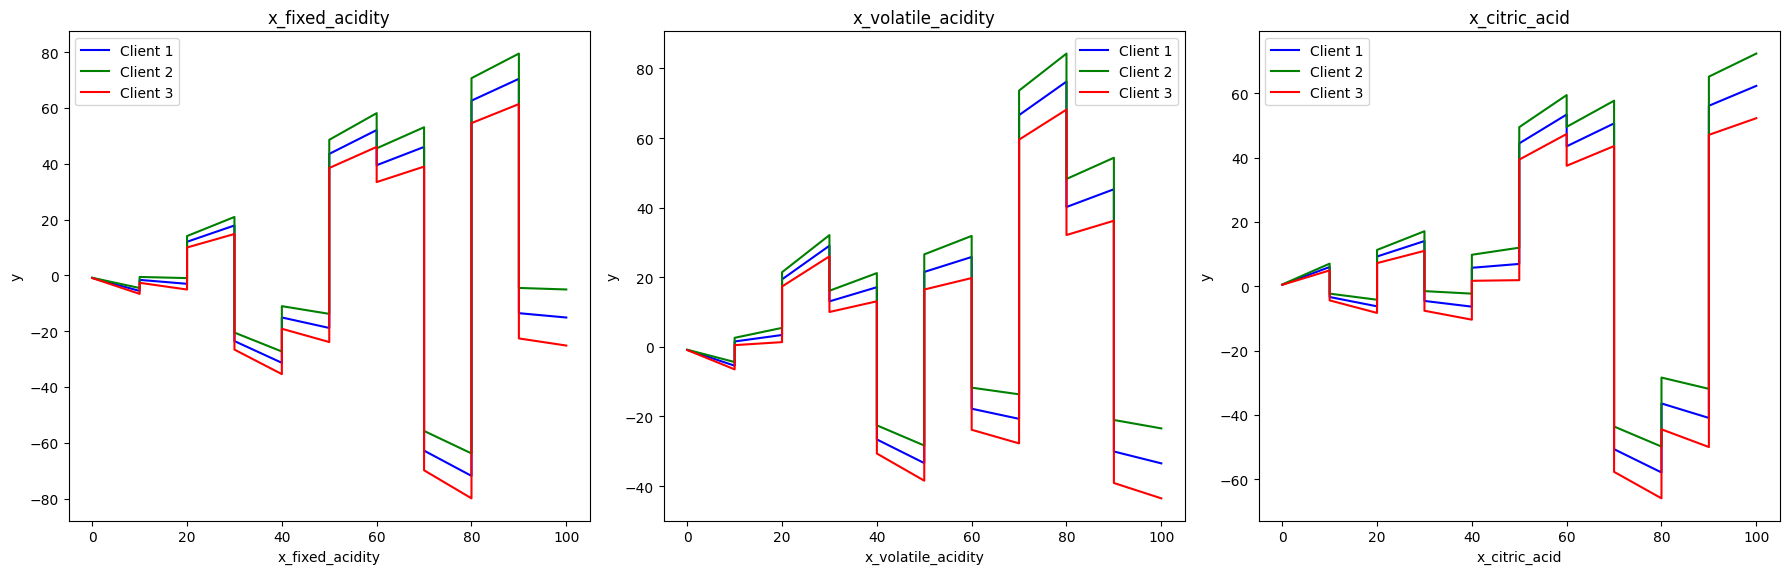

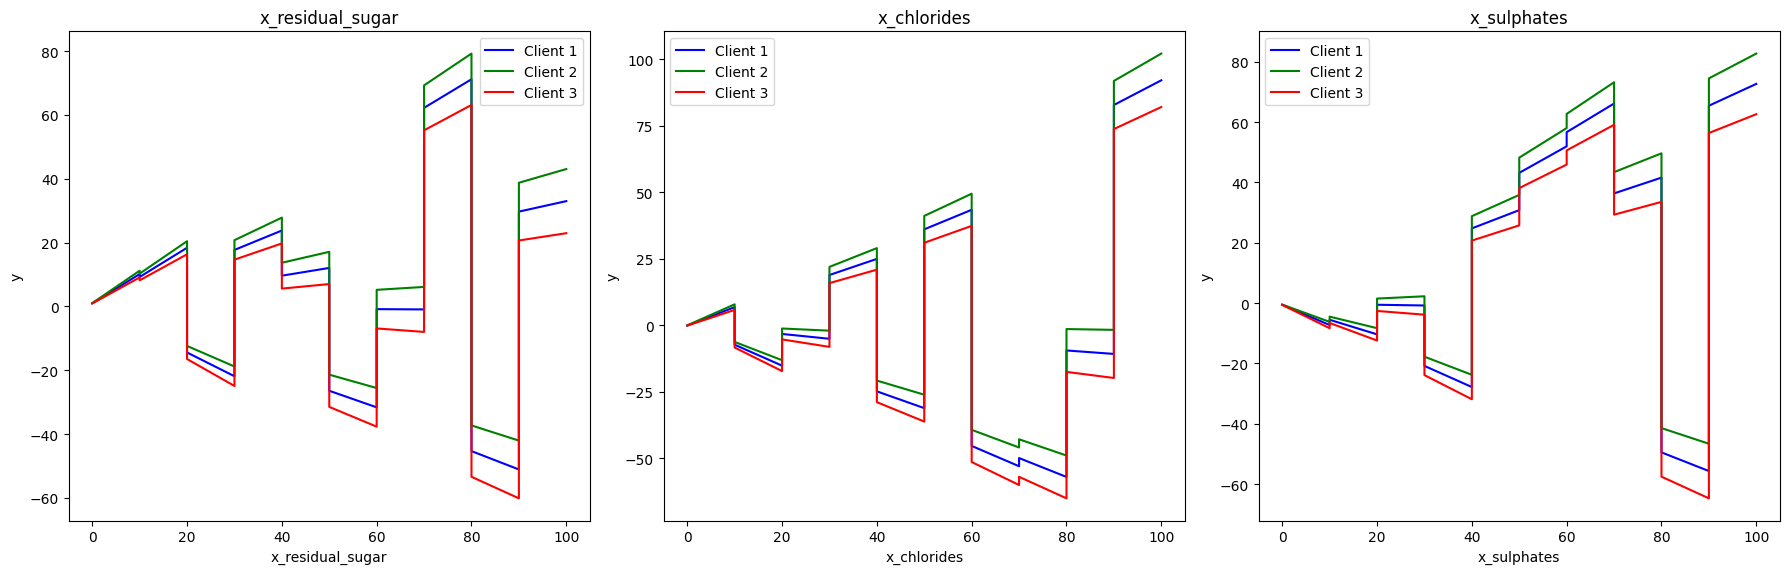

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients_client1 = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

coefficients_client2 = {k: [coef + 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed
coefficients_client3 = {k: [coef - 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed

intercepts_client1 = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826],
    "x_sulphates": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369],
    "x_alcohol": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
}

intercepts_client2 = {k: [intercept + 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed
intercepts_client3 = {k: [intercept - 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid']
selected_features_2 = ['x_residual_sugar', 'x_chlorides', 'x_sulphates']

# Plot the first set of 3 selected plots horizontally, with plots for different clients
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_1_horizontal_colored.png')

# Plot the second set of 3 selected plots horizontally, with plots for different clients
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_2_horizontal_colored.png')

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients_client1 = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

coefficients_client2 = {k: [coef + 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed
coefficients_client3 = {k: [coef - 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed

intercepts_client1 = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608



SyntaxError: incomplete input (<ipython-input-2-a3d3ed015326>, line 32)

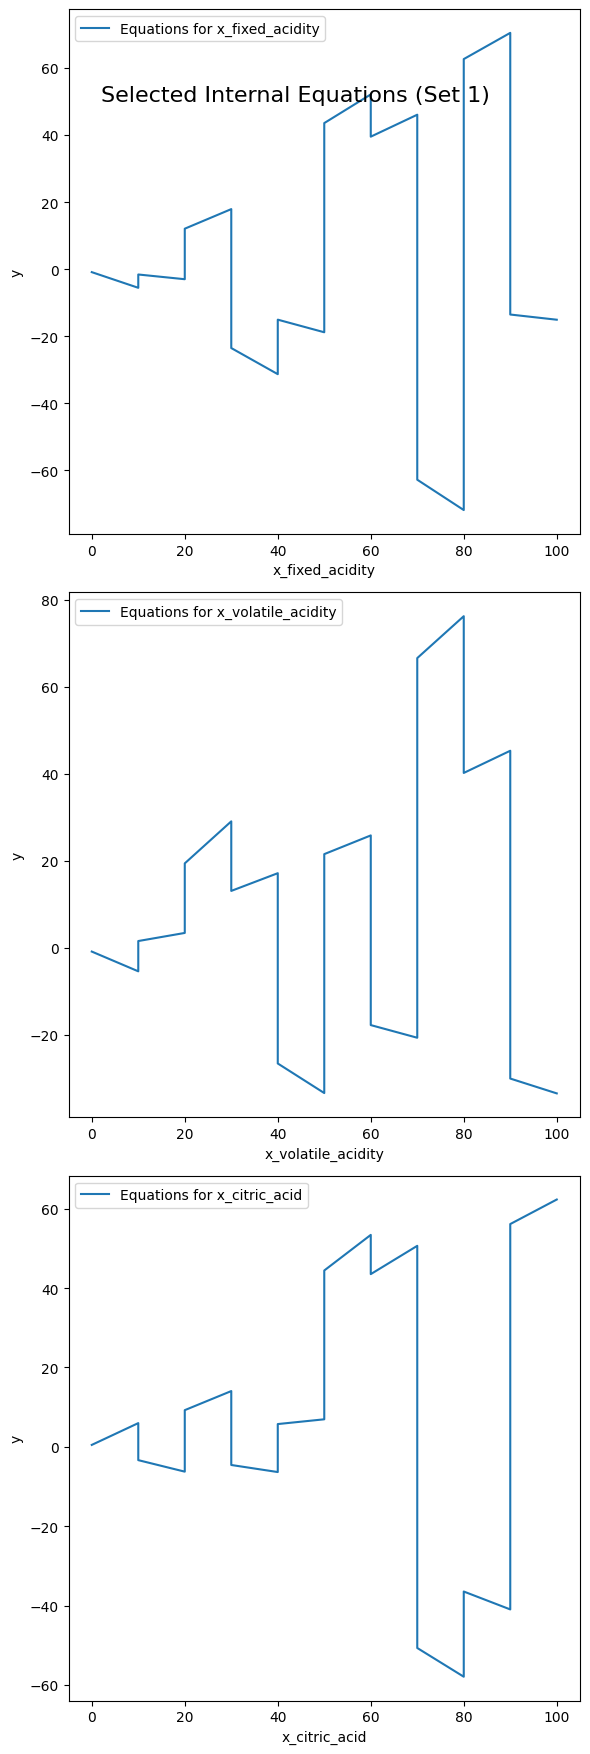

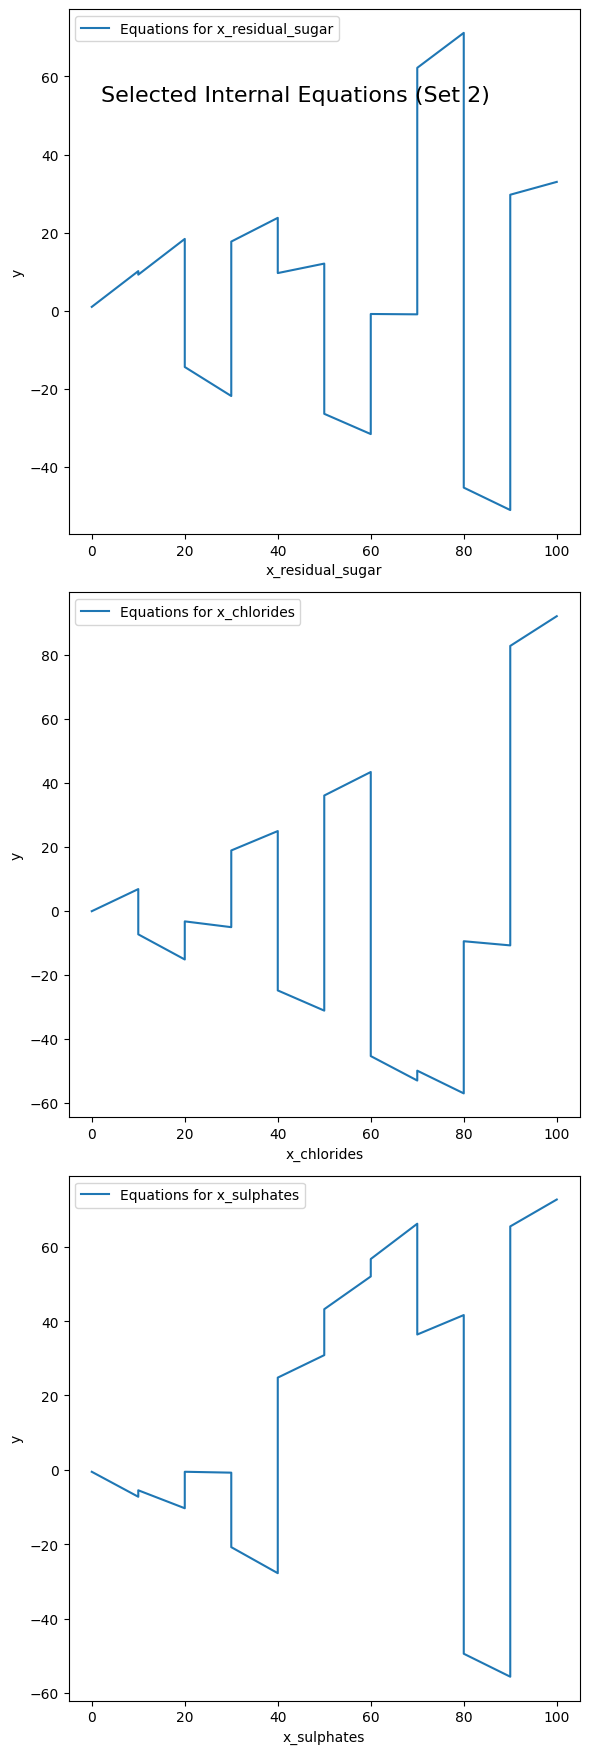

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

intercepts = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826],
    "x_sulphates": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369],
    "x_alcohol": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
}

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=f'Equations for {feature_name}')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid']
selected_features_2 = ['x_residual_sugar', 'x_chlorides', 'x_sulphates']

# Plot the first set of 3 selected plots vertically
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients, intercepts, feature, range(10))
fig.suptitle('Selected Internal Equations (Set 1)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_1.png')

# Plot the second set of 3 selected plots vertically
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients, intercepts, feature, range(10))
fig.suptitle('Selected Internal Equations (Set 2)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_2.png')

plt.show()


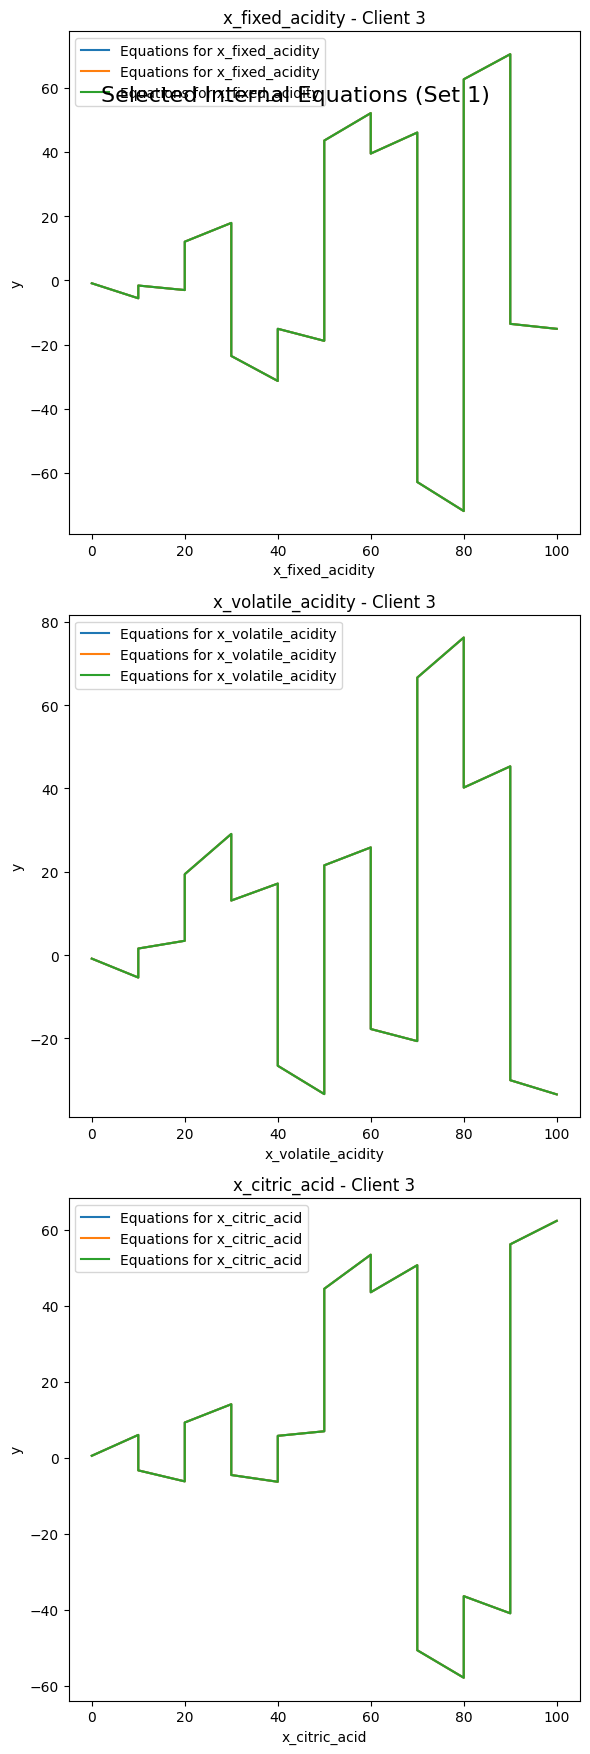

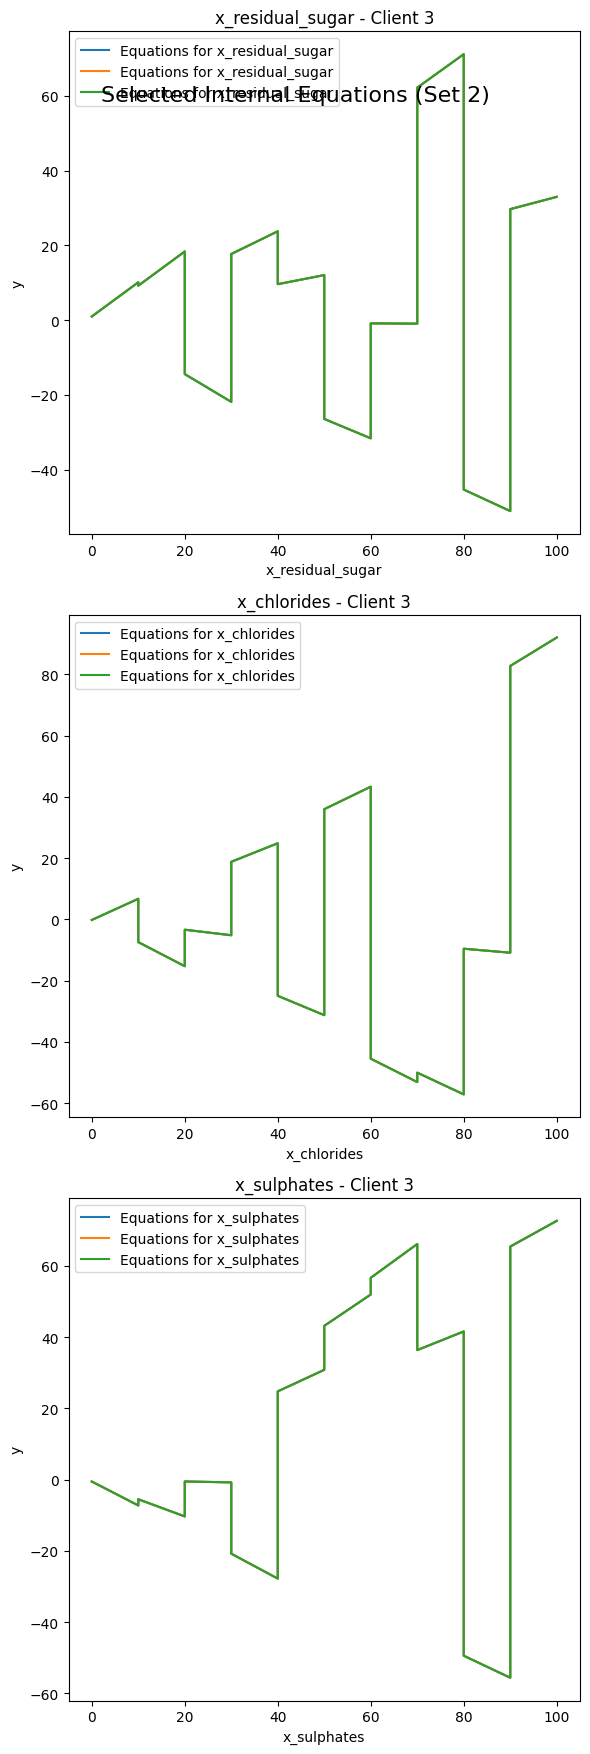

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

intercepts = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826],
    "x_sulphates": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369],
    "x_alcohol": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
}

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=f'Equations for {feature_name}')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid']
selected_features_2 = ['x_residual_sugar', 'x_chlorides', 'x_sulphates']

# Plot the first set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
clients = ['Client 1', 'Client 2', 'Client 3']
for i, feature in enumerate(selected_features_1):
    for client in clients:
        plot_connected_equations(axs[i], coefficients, intercepts, feature, range(10))
        axs[i].set_title(f'{feature} - {client}')
fig.suptitle('Selected Internal Equations (Set 1)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_1.png')

# Plot the second set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
for i, feature in enumerate(selected_features_2):
    for client in clients:
        plot_connected_equations(axs[i], coefficients, intercepts, feature, range(10))
        axs[i].set_title(f'{feature} - {client}')
fig.suptitle('Selected Internal Equations (Set 2)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_2.png')
plt.show()


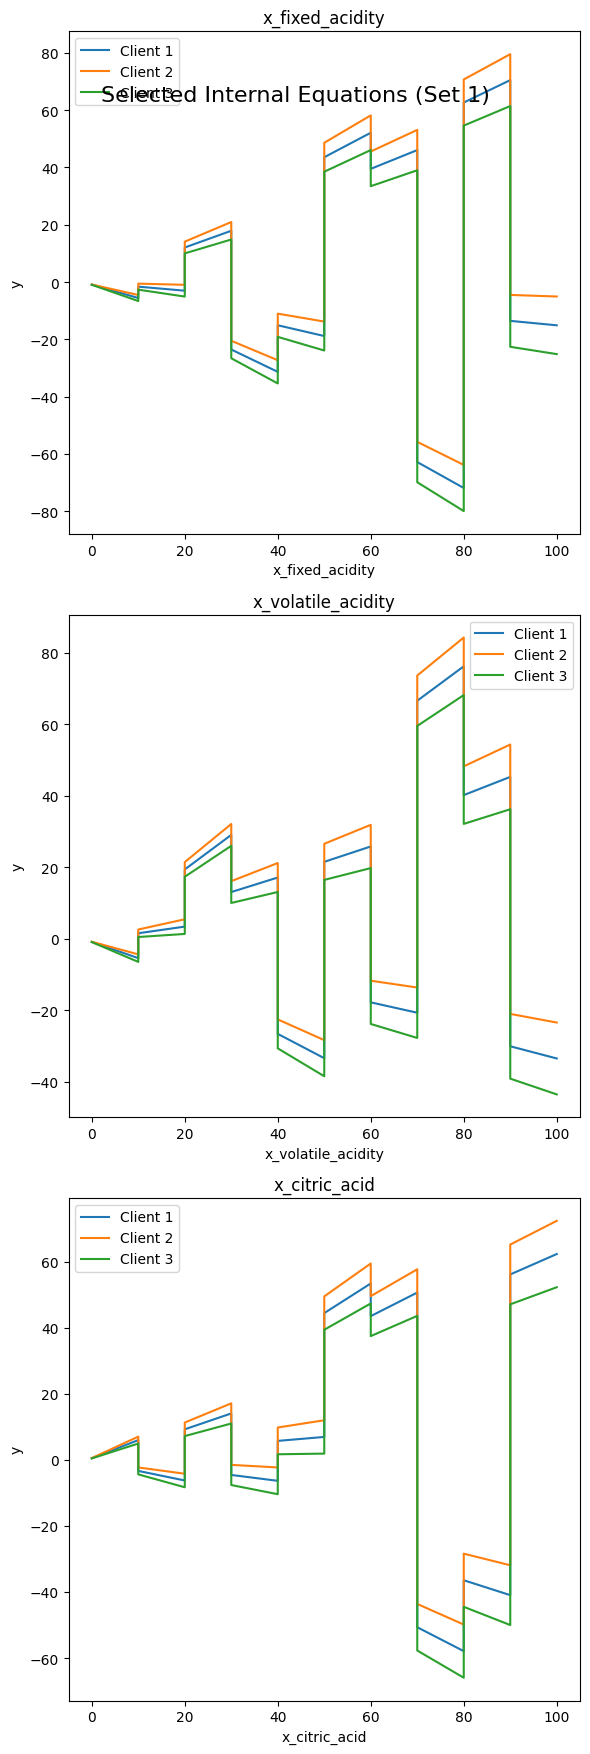

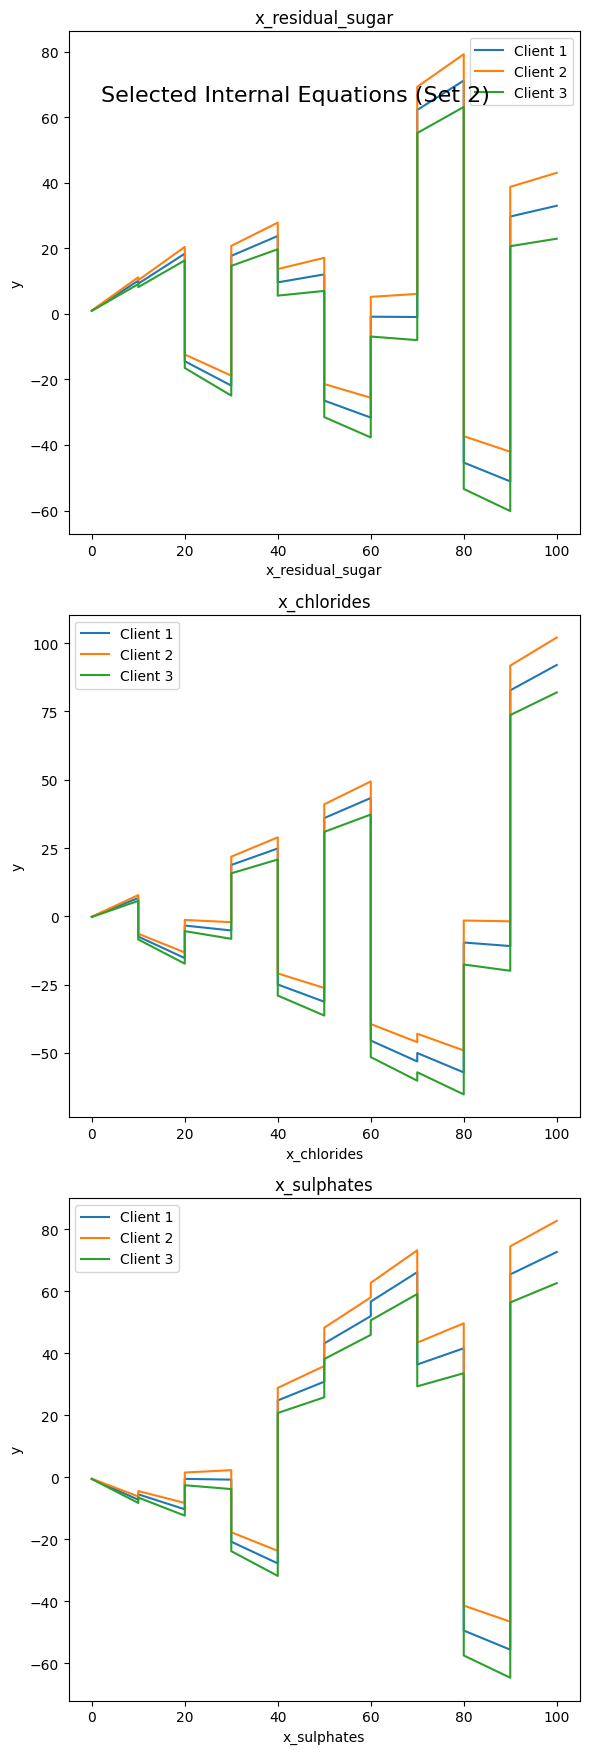

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients_client1 = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

coefficients_client2 = {k: [coef + 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed
coefficients_client3 = {k: [coef - 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed

intercepts_client1 = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826],
    "x_sulphates": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369],
    "x_alcohol": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
}

intercepts_client2 = {k: [intercept + 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed
intercepts_client3 = {k: [intercept - 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid']
selected_features_2 = ['x_residual_sugar', 'x_chlorides', 'x_sulphates']

# Plot the first set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
clients = ['Client 1', 'Client 2', 'Client 3']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('Selected Internal Equations (Set 1)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_1.png')

# Plot the second set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(6, 18))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('Selected Internal Equations (Set 2)', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_2.png')

plt.show()


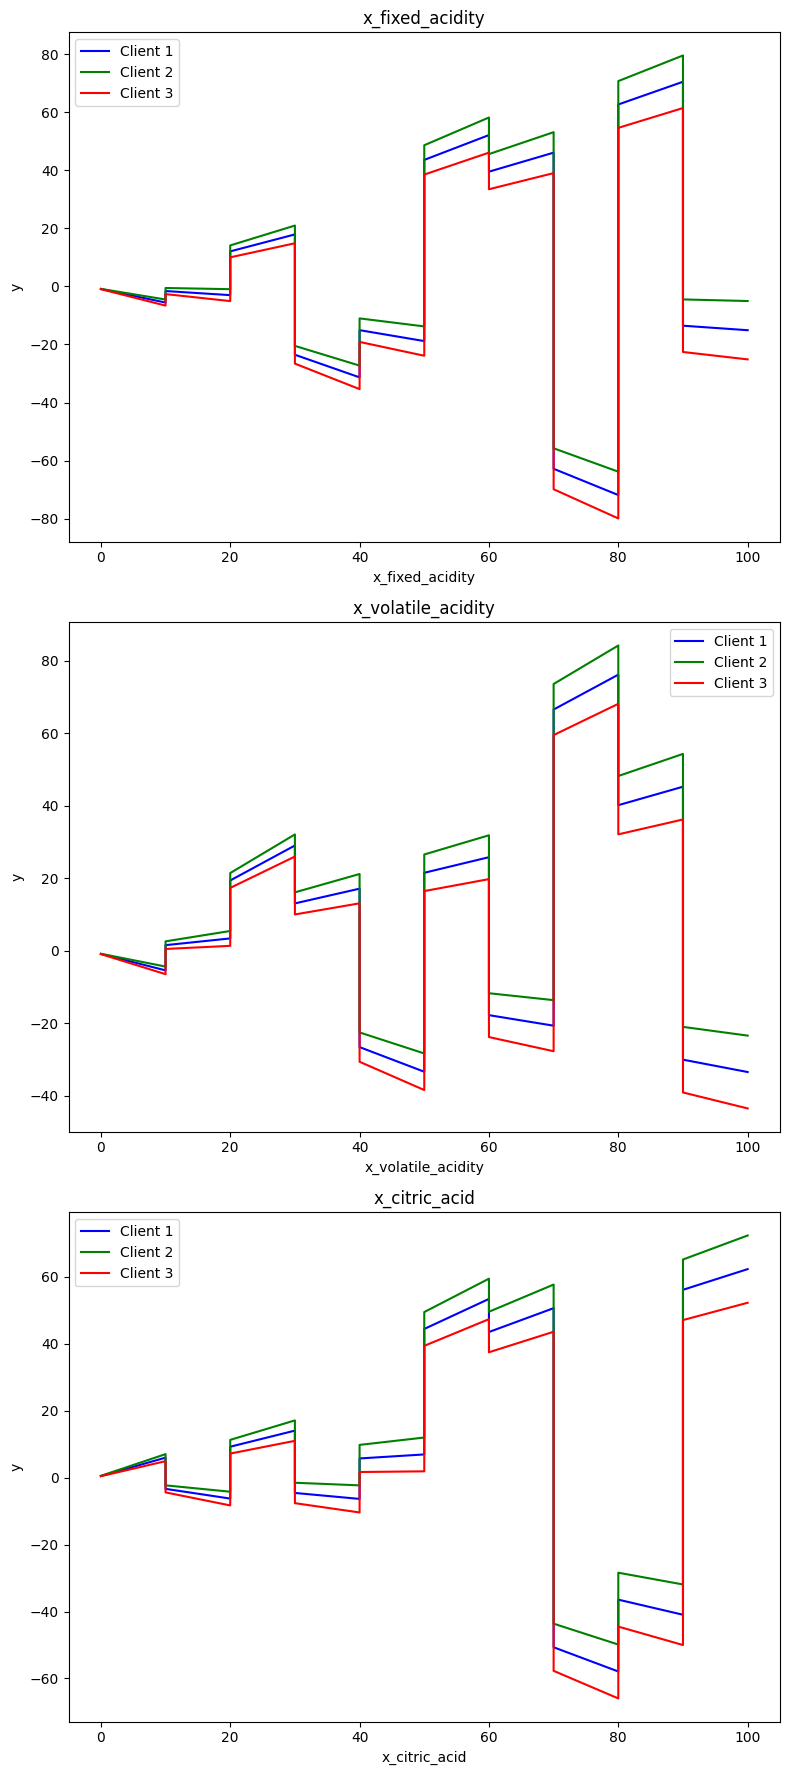

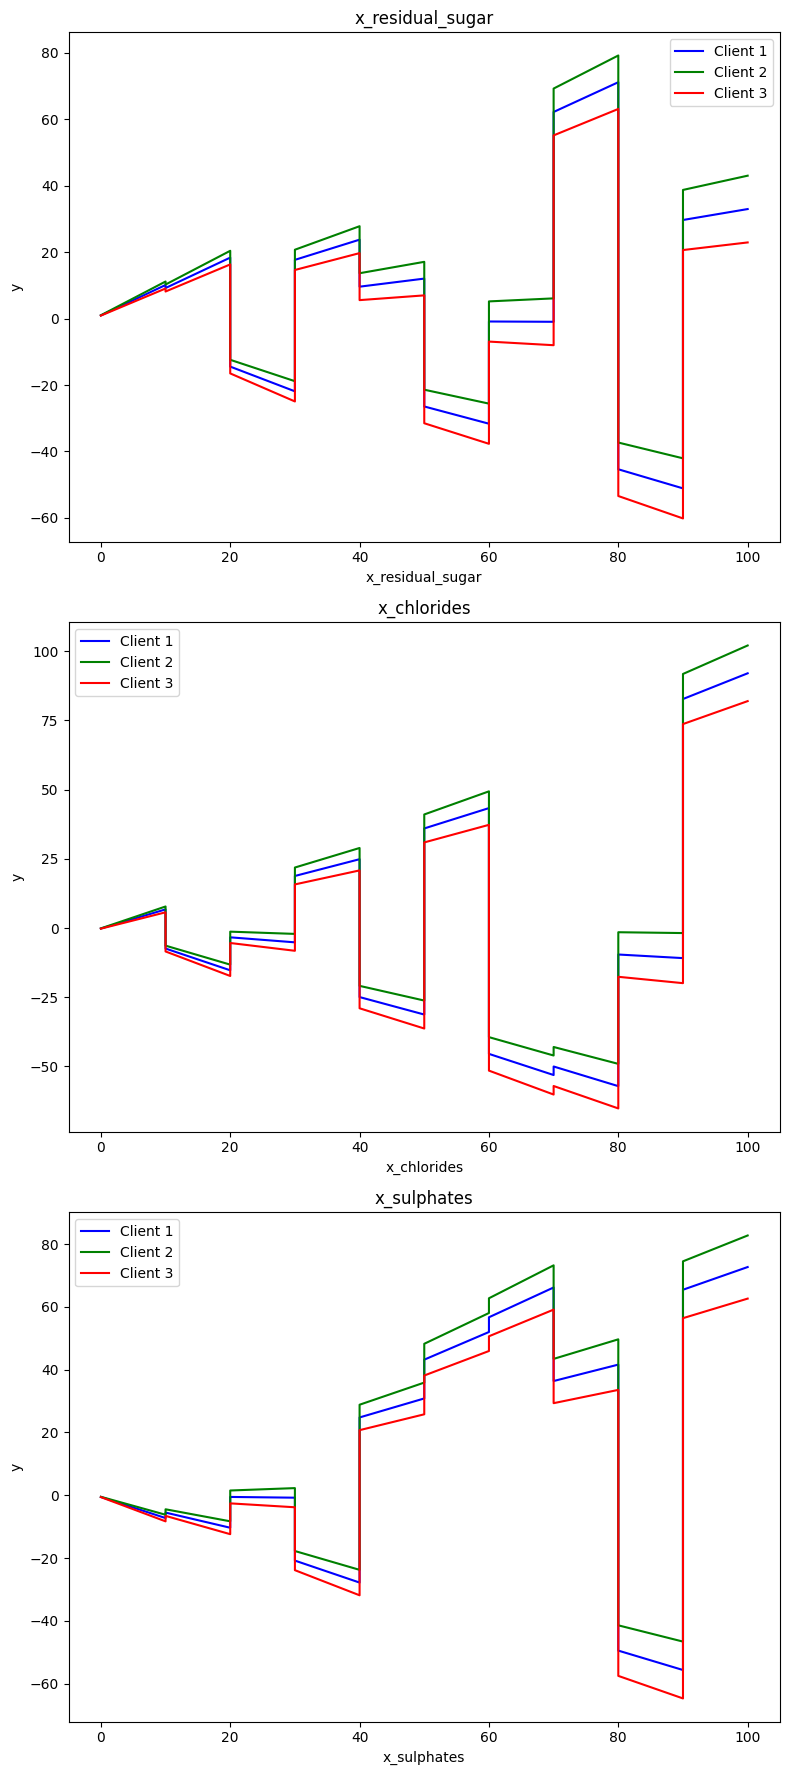

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients_client1 = {
    "x_fixed_acidity": [-0.467, -0.141, 0.584, -0.779, -0.376, 0.855, 0.655, -0.905, 0.782, -0.155],
    "x_volatile_acidity": [-0.454, 0.186, 0.966, 0.407, -0.680, 0.430, -0.291, 0.963, 0.510, -0.341],
    "x_citric_acid": [0.549, -0.290, 0.481, -0.178, 0.120, 0.897, 0.713, -0.724, -0.451, 0.618],
    "x_residual_sugar": [0.916, 0.916, -0.744, 0.608, 0.243, -0.519, -0.009, 0.896, -0.575, 0.329],
    "x_chlorides": [0.691, -0.786, -0.181, 0.606, -0.631, 0.735, -0.764, -0.710, -0.130, 0.929],
    "x_free_sulfur_dioxide": [-0.122, -0.182, 0.319, 0.850, -0.441, 0.868, -0.500, 0.770, -0.653, 0.476],
    "x_total_sulfur_dioxide": [-0.099, -0.994, -0.645, -0.358, 0.618, 0.090, -0.353, -0.326, 0.313, -0.964],
    "x_density": [-0.942, 0.357, 0.287, 0.319, 0.976, 0.492, 0.801, 0.312, 0.450, -0.726],
    "x_pH": [0.587, -0.200, -0.414, 0.257, 0.252, 0.808, -0.786, 0.136, 0.342, 0.816],
    "x_sulphates": [-0.672, -0.483, -0.024, -0.700, 0.605, 0.880, 0.949, 0.523, -0.618, 0.723],
    "x_alcohol": [0.338, -0.469, -0.468, -0.678, 0.935, -0.827, 0.807, 0.360, 0.385, -0.511]
}

coefficients_client2 = {k: [coef + 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed
coefficients_client3 = {k: [coef - 0.1 for coef in v] for k, v in coefficients_client1.items()}  # Modify as needed

intercepts_client1 = {
    "x_fixed_acidity": [-0.913, -0.205, 0.363, -0.181, -0.045, 0.788, 0.186, 0.537, 0.064, 0.398],
    "x_volatile_acidity": [-0.866, -0.306, 0.084, 0.866, 0.613, 0.029, -0.305, -0.823, -0.611, 0.637],
    "x_citric_acid": [0.492, -0.447, -0.372, 0.772, 0.943, -0.411, 0.742, 0.003, -0.370, 0.518],
    "x_residual_sugar": [0.961, 0.053, 0.431, -0.546, -0.101, -0.502, -0.325, -0.499, 0.637, 0.088],
    "x_chlorides": [-0.173, 0.454, 0.266, 0.633, 0.304, -0.765, 0.382, -0.317, 0.839, -0.869],
    "x_free_sulfur_dioxide": [-0.962, 0.528, 0.538, -0.002, 0.906, -0.136, -0.589, 0.213, -0.793, -0.917],
    "x_total_sulfur_dioxide": [-0.359, -0.974, -0.647, -0.099, -0.005, 0.460, -0.509, 0.840, -0.643, -0.179],
    "x_density": [0.226, 0.790, -0.930, -0.649, 0.112, 0.114, 0.237, 0.370, -0.169, -0.934],
    "x_pH": [-0.646, -0.804, -0.576, 0.342, -0.608, -0.124, 0.225, 0.205, 0.175, 0.826],
    "x_sulphates": [-0.541, -0.688, -0.057, 0.192, 0.577, -0.819, -0.267, -0.239, -0.031, 0.369],
    "x_alcohol": [-0.058, 0.316, -0.457, 0.187, -0.279, -0.762, 0.931, 0.894, -0.566, -0.187]
}

intercepts_client2 = {k: [intercept + 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed
intercepts_client3 = {k: [intercept - 0.05 for intercept in v] for k, v in intercepts_client1.items()}  # Modify as needed

# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid', 'x_residual_sugar', 'x_chlorides',
            'x_free_sulfur_dioxide', 'x_total_sulfur_dioxide', 'x_density', 'x_pH', 'x_sulphates', 'x_alcohol']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_fixed_acidity', 'x_volatile_acidity', 'x_citric_acid']
selected_features_2 = ['x_residual_sugar', 'x_chlorides', 'x_sulphates']

# Plot the first set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(8, 18))
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_1_vertical_colored.png')

# Plot the second set of 3 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(3, 1, figsize=(8, 18))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=16)
plt.tight_layout()
plt.savefig('selected_plots_2_vertical_colored.png')

plt.show()
